In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746526 sha256=72a68c490aa87362c6e2cdcbb742f812f23815b1a2ec9e4a76c9e58c98ccf61f
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [4]:
import gdown
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [5]:
url = "https://drive.google.com/file/d/1JlPOaCgodsr0l9rXjjGpSC945WAefuSU/view?usp=sharing"
output = "cat.png"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1JlPOaCgodsr0l9rXjjGpSC945WAefuSU
To: /home/bogdan/skoltech/hppl/cat.png
100%|██████████| 58.7k/58.7k [00:00<00:00, 1.84MB/s]


'cat.png'

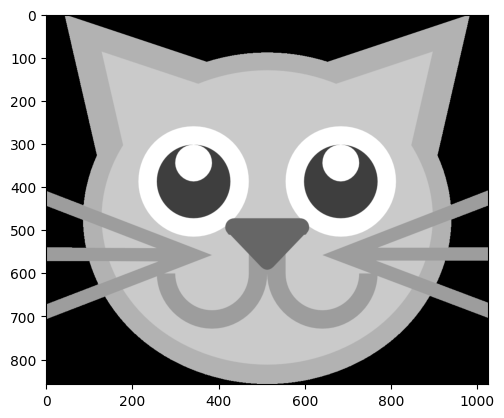

In [6]:
image = cv2.imread(output, 0)
plt.imshow(image, cmap='gray')

In [7]:
def shift_image(image, n=1):
    buffer = np.empty(image.shape, dtype=np.uint8)
    buffer[:, n:] = image[:, :-n]
    buffer[:, :n] = image[:, -n:]

    return buffer

def apply_shifts(image):
    shifted_image = image
    for i in range(31):
        cv2.imwrite(f'single_image{i}.png', shifted_image)
        shifted_image = shift_image(shifted_image)

In [8]:
apply_shifts(image)

In [9]:
def get_images():
    images = []
    for i in range(31):
        image = cv2.imread(f'single_image{i}.png', 0)
        images.append(image)
    return images

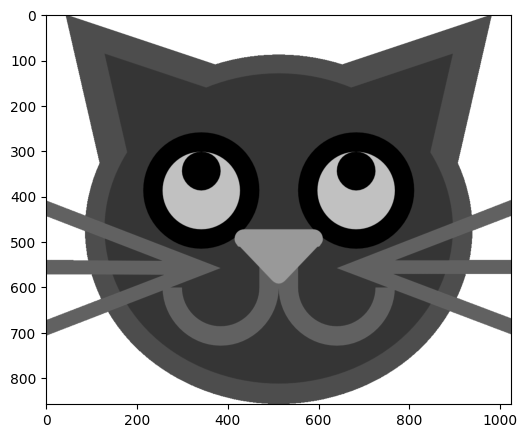

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
images = get_images()
def animate(frame):
    ax.clear()

    img = ax.imshow(images[frame], cmap=cm.binary)
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=31, interval=10, blit=True, repeat=True)
plt.show()

In [11]:
anim.save('animation.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


In [12]:
%%writefile shift.py
from mpi4py import MPI
import numpy as np
import cv2
import sys

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

root = 0
N_global = int(sys.argv[3])
L = int(sys.argv[2])
my_N = N_global // size
remainder = N_global % size
my_buffer = np.empty(L, dtype=np.uint8)

id_left_neighbour  = (size + rank - 1) % size
id_right_neighbour = (rank + 1) % size

if (rank < remainder):
    my_N = my_N + 1

if rank == root:
    image = cv2.imread(sys.argv[1], 0)
    arrays = np.array_split(image.T, size)
    for i, array in enumerate(arrays[1:]):
        comm.Send(array.reshape(-1, ), dest=i+1, tag=i)
    my_part = arrays[0]

else:
    my_part = np.empty((my_N*L, ), dtype=np.uint8)
    comm.Recv([my_part, my_N * L, MPI.INT], source=root, tag=rank-1)
    my_part = my_part.reshape(my_N, -1)

for i in range(31):
    comm.Send(np.ascontiguousarray(my_part[-1]), dest=id_right_neighbour, tag=0)
    my_part[1:] = my_part[:-1].copy()
    comm.Recv([my_buffer[:], L, MPI.INT], source=id_left_neighbour, tag=0)
    my_part[0] = my_buffer.copy()

    imgs = comm.gather(my_part, root=root)
    if rank == root:
        for j, img in enumerate(imgs):
            cv2.imwrite(f'{i}_{j}.png', img)

        cv2.imwrite(f'{i}_all.png', np.concatenate(imgs, axis=0).T)
        cv2.imwrite(f'multi_image{i}.png', np.concatenate(imgs, axis=0).T)

MPI.Finalize()

Writing shift.py


In [14]:
!mpirun -n 4 --allow-run-as-root --oversubscribe python3 shift.py 'cat.png' 858 1025

In [15]:
def get_images():
    images = []
    for i in range(31):
        image = cv2.imread(f'multi_image{i}.png', 0)
        images.append(image)
    return images

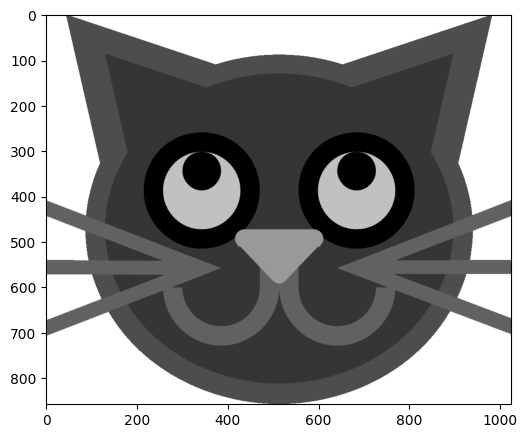

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
images = get_images()
def animate(frame):
    ax.clear()

    img = ax.imshow(images[frame], cmap=cm.binary)
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=31, interval=10, blit=True, repeat=True)
plt.show()

In [17]:
anim.save('animation1.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.
